<a href="https://colab.research.google.com/github/AhUhmm/mediterrania_survey_response/blob/main/Generazione_survey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Prima cella - Installazione dipendenze
!pip install openpyxl

In [ ]:
# Seconda cella - Importazioni e setup
from google.colab import files
import pandas as pd
import numpy as np
from datetime import datetime
from typing import List, Dict, Optional, Tuple
import logging
from dataclasses import dataclass
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pathlib import Path
from enum import Enum

%matplotlib inline

# Configurazione logging e stile
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn')

# Definizione formati export
class ExportFormat(Enum):
    """Formati di export supportati"""
    EXCEL = 'xlsx'
    JSON = 'json'

<ipython-input-2-4b41e8ad6120>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
# Terza cella - Definizione classi base
@dataclass
class PopulationParams:
    """Parametri della popolazione italiana basati su ISTAT 2022"""
    MALE_HEIGHT_MEAN: float = 175.2
    MALE_HEIGHT_STD: float = 7.0
    FEMALE_HEIGHT_MEAN: float = 162.5
    FEMALE_HEIGHT_STD: float = 6.5
    MALE_WEIGHT_MEAN: float = 77.5
    MALE_WEIGHT_STD: float = 12.0
    FEMALE_WEIGHT_MEAN: float = 63.5
    FEMALE_WEIGHT_STD: float = 11.0

    MIN_HEALTHY_BMI: float = 18.5
    MAX_HEALTHY_BMI: float = 29.9
    ABSOLUTE_MIN_BMI: float = 16.0
    ABSOLUTE_MAX_BMI: float = 35.0

class HealthCondition:
    """Gestione delle condizioni di salute e loro correlazioni"""
    CONDITIONS = {
        'Diabete': 0.06,
        'Ipertensione': 0.12,
        'Celiachia': 0.01,
        'Ipotiroidismo': 0.03,
        'Nessuna': 0.78
    }

    DIET_CORRELATIONS = {
        'Diabete': {'gluten-free': 0.1, 'low-carb': 0.4},
        'Celiachia': {'gluten-free': 1.0},
        'Ipertensione': {'low-sodium': 0.6}
    }

class AllergyManager:
    """Gestione avanzata delle allergie con validazione"""
    FOOD_ALLERGIES = {
        'Nessuna': 0.92,
        'Arachidi': 0.01,
        'Frutta secca': 0.015,
        'Pesce': 0.008,
        'Crostacei': 0.006,
        'Latte': 0.02,
        'Uova': 0.007,
        'Soia': 0.004,
        'Sesamo': 0.003,
        'Senape': 0.002,
        'Lupini': 0.002,
        'Molluschi': 0.005,
        'Sedano': 0.003,
        'Kiwi': 0.004
    }

    DRUG_ALLERGIES = {
        'Nessuna': 0.93,
        'Penicillina': 0.04,
        'Sulfamidici': 0.015,
        'FANS': 0.015
    }

    ALLERGY_CORRELATIONS = {
        'Crostacei': ['Molluschi'],
        'Arachidi': ['Frutta secca'],
        'Pesce': ['Crostacei', 'Molluschi']
    }

    @staticmethod
    def validate_allergies(allergies: List[str]) -> bool:
        if not allergies or 'Nessuna' in allergies:
            return len(allergies) == 0 or (len(allergies) == 1 and allergies[0] == 'Nessuna')
        return len(allergies) <= 3

In [ ]:
# Quarta cella - Prima parte classe SurveyDataGenerator
class SurveyDataGenerator:
    def __init__(self):
        self.params = PopulationParams()
        self.health_manager = HealthCondition()
        self.allergy_manager = AllergyManager()

    def calculate_bmi(self, height_cm: float, weight_kg: float) -> float:
        """Calcola il BMI e valida che sia nel range accettabile"""
        height_m = height_cm / 100
        bmi = weight_kg / (height_m * height_m)
        return round(bmi, 1)

    def validate_measurements(self, gender: str, age: int, height: float, weight: float) -> bool:
        """Valida le misurazioni antropometriche"""
        bmi = self.calculate_bmi(height, weight)

        if not (18 <= age <= 75):
            logging.warning(f"Età {age} fuori range")
            return False

        if not (140 <= height <= 210):
            logging.warning(f"Altezza {height} fuori range")
            return False

        if not (self.params.ABSOLUTE_MIN_BMI <= bmi <= self.params.ABSOLUTE_MAX_BMI):
            logging.warning(f"BMI {bmi} fuori range accettabile")
            return False

        return True

    def generate_health_profile(self, age: int) -> Tuple[str, List[str]]:
        """Genera profilo di salute con condizioni correlate all'età"""
        conditions = []
        diet_restrictions = []

        age_factor = min((age - 18) / 57, 1)

        for condition, base_prob in self.health_manager.CONDITIONS.items():
            if condition != 'Nessuna':
                adjusted_prob = base_prob * (1 + age_factor)
                if np.random.random() < adjusted_prob:
                    conditions.append(condition)

                    if condition in self.health_manager.DIET_CORRELATIONS:
                        for diet, prob in self.health_manager.DIET_CORRELATIONS[condition].items():
                            if np.random.random() < prob:
                                diet_restrictions.append(diet)

        if not conditions:
            conditions = ['Nessuna']

        return conditions, list(set(diet_restrictions))

    def generate_dietary_preferences(self, health_conditions: List[str], diet_restrictions: List[str]) -> str:
        """Genera preferenze dietetiche considerando condizioni di salute"""
        base_preferences = {
            'nessuno': 0.80,
            'vegetariano': 0.08,
            'vegano': 0.05,
            'gluten-free': 0.05,
            'altro': 0.02
        }

        if 'Celiachia' in health_conditions or 'gluten-free' in diet_restrictions:
            return 'gluten-free'

        if 'low-carb' in diet_restrictions:
            base_preferences['altro'] = 0.2
            base_preferences['nessuno'] = 0.62

        preferences = list(base_preferences.keys())
        probabilities = list(base_preferences.values())

        return np.random.choice(preferences, p=probabilities)

    def generate_fruit_preferences(self, health_conditions: List[str]) -> Dict:
        """Genera preferenze frutta considerando condizioni di salute"""
        base_consumption = np.random.randint(0, 6)

        if 'Diabete' in health_conditions:
            base_consumption = min(base_consumption, 3)

        timing_options = ['Mattina', 'Pomeriggio', 'Sera']
        num_timings = np.random.choice([1, 2, 3], p=[0.5, 0.3, 0.2])
        timings = list(np.random.choice(timing_options, size=num_timings, replace=False))

        return {
            'portions': base_consumption,
            'timing': timings
        }

    def generate_plant_milk_preferences(self, allergies: List[str]) -> List[str]:
        """Genera preferenze latte vegetale considerando allergie"""
        options = ['Soia', 'Riso', 'Avena', 'Nocciola']

        if 'Soia' in allergies:
            options.remove('Soia')
        if 'Frutta secca' in allergies:
            if 'Nocciola' in options:
                options.remove('Nocciola')

        num_choices = np.random.choice([0, 1, 2], p=[0.3, 0.5, 0.2])
        if num_choices == 0 or not options:
            return []

        return list(np.random.choice(options, size=min(num_choices, len(options)), replace=False))

    def generate_weight_target(self, current_weight: float, bmi: float,
                             objective: str) -> Optional[float]:
        """Genera target peso realistico"""
        if objective != 'Perdere peso':
            return None

        min_loss = current_weight * 0.05
        max_loss = current_weight * 0.15

        if bmi < 22:
            max_loss = min(max_loss, current_weight * 0.08)

        loss = np.random.uniform(min_loss, max_loss)
        target = round(current_weight - loss, 1)

        return target

    def generate_survey_response(self) -> Dict:
        """Genera una risposta al sondaggio completa e validata"""
        while True:
            try:
                gender = np.random.choice(['F', 'M'], p=[0.512, 0.488])
                age = np.random.choice(range(18, 76), p=np.array([2 if 30 <= x <= 60 else 1 for x in range(18, 76)])/sum([2 if 30 <= x <= 60 else 1 for x in range(18, 76)]))

                if gender == 'M':
                    height = round(np.random.normal(self.params.MALE_HEIGHT_MEAN, self.params.MALE_HEIGHT_STD))
                    weight = round(np.random.normal(self.params.MALE_WEIGHT_MEAN, self.params.MALE_WEIGHT_STD), 1)
                else:
                    height = round(np.random.normal(self.params.FEMALE_HEIGHT_MEAN, self.params.FEMALE_HEIGHT_STD))
                    weight = round(np.random.normal(self.params.FEMALE_WEIGHT_MEAN, self.params.FEMALE_WEIGHT_STD), 1)

                if not self.validate_measurements(gender, age, height, weight):
                    continue

                health_conditions, diet_restrictions = self.generate_health_profile(age)
                diet_preference = self.generate_dietary_preferences(health_conditions, diet_restrictions)

                food_allergies = []
                drug_allergies = []
                has_allergies = np.random.choice([True, False], p=[0.15, 0.85])

                if has_allergies:
                    for allergy, prob in self.allergy_manager.FOOD_ALLERGIES.items():
                        if np.random.random() < prob and allergy != 'Nessuna':
                            food_allergies.append(allergy)

                    for allergy, prob in self.allergy_manager.DRUG_ALLERGIES.items():
                        if np.random.random() < prob and allergy != 'Nessuna':
                            drug_allergies.append(allergy)

                if not self.allergy_manager.validate_allergies(food_allergies):
                    continue

                objective = np.random.choice([
                    'Perdere peso',
                    'Mantenere peso',
                    'Aumentare massa muscolare'
                ], p=[0.5, 0.3, 0.2])

                bmi = self.calculate_bmi(height, weight)
                target_weight = self.generate_weight_target(weight, bmi, objective)

                fruit_prefs = self.generate_fruit_preferences(health_conditions)
                plant_milk_prefs = self.generate_plant_milk_preferences(food_allergies)

                return {
                    'gender': gender,
                    'age': age,
                    'height': height,
                    'weight': weight,
                    'bmi': bmi,
                    'objective': objective,
                    'target_weight': target_weight,
                    'health_conditions': health_conditions,
                    'diet_preference': diet_preference,
                    'diet_restrictions': diet_restrictions,
                    'has_allergies': has_allergies,
                    'food_allergies': food_allergies,
                    'drug_allergies': drug_allergies,
                    'plant_milk_preferences': plant_milk_prefs,
                    'fruit_pieces_per_day': fruit_prefs['portions'],
                    'fruit_timing': fruit_prefs['timing']
                }

            except Exception as e:
                logging.error(f"Errore nella generazione dati: {str(e)}")
                continue

    def generate_dataset(self, n_samples: int = 300) -> pd.DataFrame:
        """Genera dataset completo con n campioni"""
        responses = []
        generated = 0

        while generated < n_samples:
            try:
                response = self.generate_survey_response()
                # Aggiungi ID utente progressivo
                response['id_utente'] = generated + 1  # Aggiungiamo questa riga
                responses.append(response)
                generated += 1

                if generated % 50 == 0:
                    logging.info(f"Generati {generated}/{n_samples} profili")

            except Exception as e:
                logging.error(f"Errore nella generazione del profilo {generated}: {str(e)}")
                continue

        df = pd.DataFrame(responses)
        # Riorganizza le colonne per mettere l'ID all'inizio
        cols = ['id_utente'] + [col for col in df.columns if col != 'id_utente']
        df = df[cols]
        return df



In [ ]:
# Ottava cella - Funzioni di preparazione dati e export
def prepare_data_for_export(df: pd.DataFrame) -> pd.DataFrame:
    """Prepara il dataset per l'export applicando le necessarie trasformazioni"""
    column_mapping = {
        'id_utente': 'ID Utente',  # Aggiungiamo questa riga
        'gender': 'Sesso',
        'age': 'Età',
        'height': 'Altezza (cm)',
        'weight': 'Peso (kg)',
        'bmi': 'BMI',
        'objective': 'Obiettivo',
        'target_weight': 'Peso Target (kg)',
        'health_conditions': 'Condizioni di Salute',
        'diet_preference': 'Preferenza Dietetica',
        'diet_restrictions': 'Restrizioni Dietetiche',
        'has_allergies': 'Ha Allergie',
        'food_allergies': 'Allergie Alimentari',
        'drug_allergies': 'Allergie ai Farmaci',
        'plant_milk_preferences': 'Preferenze Latte Vegetale',
        'fruit_pieces_per_day': 'Porzioni Frutta al Giorno',
        'fruit_timing': 'Momento Consumo Frutta'
    }

    df_export = df.copy()

    # Converti liste in stringhe prima di rinominare
    list_columns = ['health_conditions', 'diet_restrictions', 'food_allergies',
                   'drug_allergies', 'plant_milk_preferences', 'fruit_timing']
    for col in list_columns:
        df_export[col] = df_export[col].apply(lambda x: ', '.join(x) if x else 'Nessuna')

    # Rinomina le colonne dopo la conversione
    df_export = df_export.rename(columns=column_mapping)

    return df_export

def export_to_excel(df: pd.DataFrame, filename: str) -> None:
   """Esporta il dataset in formato Excel con formattazione appropriata"""
   with pd.ExcelWriter(filename, engine='openpyxl') as writer:
       df.to_excel(writer, index=False, sheet_name='Risposte')
       worksheet = writer.sheets['Risposte']

       for column in worksheet.columns:
           max_length = 0
           column = [cell for cell in column]
           for cell in column:
               try:
                   if len(str(cell.value)) > max_length:
                       max_length = len(cell.value)
               except:
                   pass
           adjusted_width = (max_length + 2)
           worksheet.column_dimensions[column[0].column_letter].width = adjusted_width

   logging.info(f"Dataset esportato in Excel: {filename}")

def export_to_json(df: pd.DataFrame, filename: str) -> None:
   """Esporta il dataset in formato JSON con struttura appropriata"""
   records = df.to_dict(orient='records')

   json_data = {
       "metadata": {
           "generated_date": datetime.now().isoformat(),
           "num_records": len(records),
           "columns": list(df.columns)
       },
       "data": records
   }

   with open(filename, 'w', encoding='utf-8') as f:
       json.dump(json_data, f, ensure_ascii=False, indent=2)

   logging.info(f"Dataset esportato in JSON: {filename}")

In [ ]:
# Nona cella - Funzione principale di export e analisi dati
def export_dataset(df: pd.DataFrame,
                 filename: str = 'survey_responses',
                 format: ExportFormat = ExportFormat.EXCEL) -> None:
   """Esporta il dataset nel formato specificato"""
   try:
       df_export = prepare_data_for_export(df)
       file_path = Path(filename).with_suffix(f'.{format.value}')

       if format == ExportFormat.EXCEL:
           export_to_excel(df_export, str(file_path))
       elif format == ExportFormat.JSON:
           export_to_json(df_export, str(file_path))
       else:
           raise ValueError(f"Formato non supportato: {format}")

       # Download automatico del file in Colab
       files.download(str(file_path))

   except Exception as e:
       logging.error(f"Errore durante l'export: {str(e)}")
       raise

def plot_basic_stats(df: pd.DataFrame):
   """Visualizza statistiche base del dataset"""
   fig, axes = plt.subplots(2, 2, figsize=(15, 12))

   # BMI distribution
   sns.histplot(data=df, x='bmi', hue='gender', ax=axes[0,0])
   axes[0,0].set_title('Distribuzione BMI per genere')

   # Age distribution
   sns.histplot(data=df, x='age', hue='objective', ax=axes[0,1])
   axes[0,1].set_title('Distribuzione età per obiettivo')

   # Diet preferences
   df['diet_preference'].value_counts().plot(kind='pie', ax=axes[1,0])
   axes[1,0].set_title('Preferenze dietetiche')

   # Health conditions
   health_counts = pd.Series([x for sublist in df['health_conditions'] for x in sublist]).value_counts()
   health_counts.plot(kind='bar', ax=axes[1,1])
   axes[1,1].set_title('Condizioni di salute')

   plt.tight_layout()
   plt.show()

Generazione visualizzazioni...


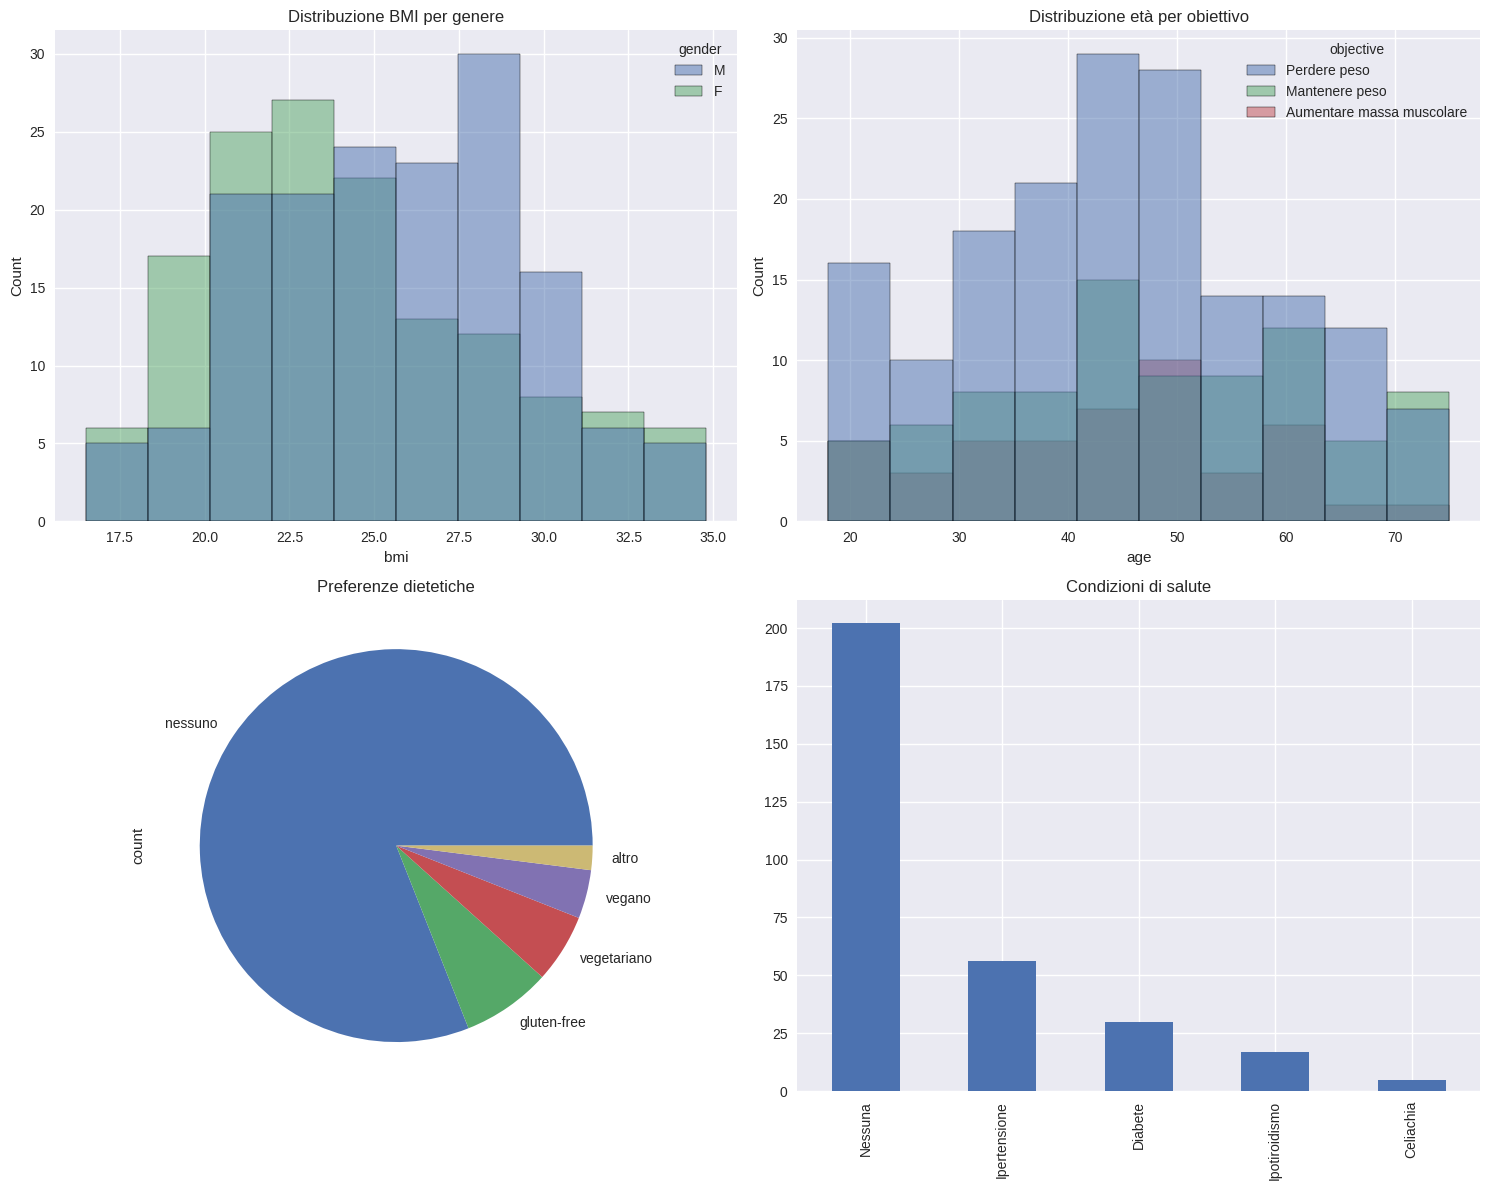


Validazione dataset:
Statistiche di validazione:
Numero totale profili: 300

Distribuzione BMI:
Min BMI: 16.5
Max BMI: 34.8
Media BMI: 25.0

Distribuzione allergie:
Profili con allergie: 51
% con allergie: 17.0%

Validazione target peso:
Profili con obiettivo perdita peso: 169
Target peso tutti validi: True

Esportazione dati...
I file verranno scaricati automaticamente...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Export completato con successo!


In [ ]:
# Decima cella - Main per esecuzione
def validate_dataset(df: pd.DataFrame) -> None:
    """Esegue controlli di validazione sul dataset"""
    print("Statistiche di validazione:")
    print(f"Numero totale profili: {len(df)}")

    print("\nDistribuzione BMI:")
    print(f"Min BMI: {df['bmi'].min():.1f}")
    print(f"Max BMI: {df['bmi'].max():.1f}")
    print(f"Media BMI: {df['bmi'].mean():.1f}")

    print("\nDistribuzione allergie:")
    print(f"Profili con allergie: {df['has_allergies'].sum()}")
    print(f"% con allergie: {(df['has_allergies'].sum() / len(df)) * 100:.1f}%")

    print("\nValidazione target peso:")
    perdita_peso = df[df['objective'] == 'Perdere peso']
    print(f"Profili con obiettivo perdita peso: {len(perdita_peso)}")
    print(f"Target peso tutti validi: {(perdita_peso['target_weight'] < perdita_peso['weight']).all()}")

def main():
    # Genera dati
    generator = SurveyDataGenerator()
    test_data = generator.generate_dataset(n_samples=300)  # Modificato da 50 a 300

    # Analisi esplorativa
    print("Generazione visualizzazioni...")
    plot_basic_stats(test_data)

    # Validazione
    print("\nValidazione dataset:")
    validate_dataset(test_data)

    # Export in entrambi i formati
    print("\nEsportazione dati...")
    try:
        print("I file verranno scaricati automaticamente...")
        export_dataset(test_data, 'survey_responses', ExportFormat.EXCEL)
        export_dataset(test_data, 'survey_responses', ExportFormat.JSON)
        print("Export completato con successo!")

    except Exception as e:
        print(f"Errore durante l'export: {str(e)}")

if __name__ == "__main__":
    main()